# Averaging ABI-GOES images for a given day:
We could try to average the images for a given day to try and reproduce the images we see on the CLS datastore.
GOES doesn't cover the same region from image to image, so we can't directly calculate the average, we'll have to calculate an average only when there is data (non-nan values). We're going to work on the same day of 24/07/2022.

## Importing necessary libraries and notebooks

In [1]:
#%matplotlib widget
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker
from IPython.display import Image
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Import the other notebooks without running their cells
from ii_Data_Manipulation import visualize_4

## time_list
First, we should write a function that generates a lost of the times in the time intervals we need to make the importation of data easier. 

In [2]:
def time_list(start_time, end_time, interval):
    """
    Generate a list of datetime strings in the format 'YYYYMMDD_HH-MM' between start_time and end_time at intervals of 'interval' minutes.
    
    Parameters:
    - start_time (datetime): The start time.
    - end_time (datetime): The end time.
    - interval (int): The interval in minutes between each time point.

    Returns:
    - times (list of str): List of formatted datetime strings.
    """
    
    # Generate a list of times at the specified interval
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time.strftime('%Y%m%d_%H-%M'))
        current_time += timedelta(minutes=interval)

    return times

## visualize_aggregate
We should first write a function **(very similar to visualize_5, maybe we should make it use visualize_5)** to visualize the aggregate motion of the algae, this function would take the aggregate_data we're going to calculate as argument instead of the path to the file.

In [3]:
def visualize_aggregate(aggregate_data, lat_range=None, lon_range=None, color="viridis", vmax=0.001, threshold=0, output_filepath=None, filter_clouds=True):
    # Select the desired subset
    if lat_range:
        aggregate_data = aggregate_data.sel(latitude=slice(*lat_range))
    if lon_range:
        aggregate_data = aggregate_data.sel(longitude=slice(*lon_range))
    
    # If filtering clouds, set NaN values to -0.1
    if filter_clouds:
        aggregate_data = xr.where(np.isnan(aggregate_data), -0.1, aggregate_data)
    
    # Set up a plot with geographic projections
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Customize the map with coastlines and features
    ax.coastlines(resolution='10m', color='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Adding grid lines and disabling labels on the top and right
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Plot the aggregate data with the specified color, vmax, and threshold
    im = aggregate_data.plot(ax=ax, x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                             cmap=color, add_colorbar=True, extend='both',
                             vmin=threshold, vmax=vmax, cbar_kwargs={'shrink': 0.35})

    # Add color bar details
    colorbar_label = 'Aggregate Floating Algae Index (FAI)' 
    im.colorbar.set_label(colorbar_label)
    
    # Show the plot with title
    plt.title("Aggregate Algae Distribution on 2022-07-24")
    plt.show()

## visualize_aggregate_plotly

In [4]:
def visualize_aggregate_plotly(aggregate_data, lat_range=None, lon_range=None, color="Viridis", vmax=0.001, threshold=0, output_filepath=None, filter_clouds=True):
    # Select the desired subset
    if lat_range:
        aggregate_data = aggregate_data.sel(latitude=slice(*lat_range))
    if lon_range:
        aggregate_data = aggregate_data.sel(longitude=slice(*lon_range))
    
    # If filtering clouds, set NaN values to -0.1
    if filter_clouds:
        aggregate_data = xr.where(np.isnan(aggregate_data), -0.1, aggregate_data)
    
    # Convert the data to a DataFrame for Plotly
    df = aggregate_data.to_dataframe().reset_index()
    
    # Filter data based on threshold
    df = df[df[aggregate_data.name] > threshold]

    # Create a 2D heatmap
    fig = go.Figure()

    # Add the heatmap trace
    fig.add_trace(go.Heatmap(
        z=df[aggregate_data.name],
        x=df['longitude'],
        y=df['latitude'],
        colorscale=color,
        zmin=threshold,
        zmax=vmax,
        colorbar=dict(title='Aggregate Floating Algae Index (FAI)')
    ))

    # Customize the layout to ensure no grey areas appear around the plot
    fig.update_layout(
        title="Aggregate Algae Distribution on 2022-07-24",
        xaxis=dict(showgrid=False, zeroline=False, range=[df['longitude'].min(), df['longitude'].max()]),
        yaxis=dict(showgrid=False, zeroline=False, range=[df['latitude'].min(), df['latitude'].max()]),
        autosize=True,
        margin=dict(l=0, r=0, t=40, b=0),  # adjust margins to ensure no empty space
        paper_bgcolor='rgba(0,0,0,0)',  # make background transparent
        plot_bgcolor='rgba(0,0,0,0)'  # ensure plot background is also transparent
    )

    # Ensure the plot stretches to fit the data precisely
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    # Save the plot if output_filepath is provided
    if output_filepath:
        fig.write_html(output_filepath, auto_open=True)
    
    # Show the plot
    fig.show()

In [5]:
# if __name__ == '__main__':
#     # Generating the time list
#     times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
#     # Calculating the median data for this time period
#     median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range= (-67, -60))
    
#     #Visualizing the result and comparing it to the mean 
#     visualize_aggregate_interactive(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

In [6]:
# if __name__ == '__main__':
#     # Generating the time list
#     times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
#     # Calculating the median data for this time period
#     median_algae_distribution = calculate_median(times,lat_range=(14, 15), lon_range= (-67, -65))
    
#     #Visualizing the result and comparing it to the mean 
#     visualize_aggregate_interactive(median_algae_distribution, (14, 15), (-67, -65), color="viridis", vmax=0.001, threshold=0)

This function allows us to zoom and it also shows the latitude, longitude and FAI of the pixel we're hovering over, although the zoom functionality is a bit finnicky. If we want just the zoom we can use **%matplotlib widget** at the beginning of our execution block.

In [7]:
# %matplotlib widget
# if __name__ == '__main__':
#     # Generating the time list
#     times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
#     # Calculating the median data for this time period
#     median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range= (-67, -60))
    
#     #Visualizing the result and comparing it to the mean 
#     visualize_aggregate(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

In [8]:
# %matplotlib widget
# if __name__ == '__main__':
#     # Generating the time list
#     times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
#     # Calculating the median data for this time period
#     median_algae_distribution = calculate_median(times)
    
#     #Visualizing the result and comparing it to the mean 
#     visualize_aggregate(median_algae_distribution, color="viridis", vmax=0.001, threshold=0)

## split_and_aggregate_median

In [9]:
def split_and_aggregate_median(lat_splits, lon_splits, time_list, threshold=0):
    """
    Splits the data into regions, calculates median for each region across given times, and aggregates back.

    Parameters:
    - data (xarray Dataset): The dataset containing the ABI data.
    - lat_splits (list of float): Latitude boundaries for splitting the dataset.
    - lon_splits (list of float): Longitude boundaries for splitting the dataset.
    - time_list (list of str): List of formatted datetime strings in the format 'YYYYMMDD_HH-MM'.
    - threshold (float): The threshold above which data is considered.

    Returns:
    - aggregated_median (xarray DataArray): The aggregated median distribution.
    """
    regional_medians = []

    # Iterate over each region defined by lat and lon splits
    for i in range(len(lat_splits) - 1):
        for j in range(len(lon_splits) - 1):
            lat_range = (lat_splits[i], lat_splits[i + 1])
            lon_range = (lon_splits[j], lon_splits[j + 1])

            # Fetch and process the median for this region
            median = calculate_median(time_list, lat_range, lon_range, threshold)
            regional_medians.append(median)
    
    # Combine using `concat` along a new dimension and then take the median of that dimension
    if regional_medians:
        combined = xr.concat(regional_medians, dim='new_dim')
        aggregated_median = combined.median(dim='new_dim')
        return aggregated_median
    else:
        return None  # or handle empty list case appropriately

In [10]:
#%matplotlib widget
if __name__ == '__main__':
    lat_splits = [12, 15.5, 19, 22.5, 26, 29.5, 33, 36.5, 40]  # Define latitude splits
    lon_splits = [-100, -89, -78, -67, -56, -45, -34, -23, -12]  # Define longitude splits
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
    # Calculating the median data for this time period
    aggregated_median = split_and_aggregate_median(lat_splits, lon_splits, times)
    
    #Visualizing the result and comparing it to the mean 
    visualize_aggregate(aggregated_median, (14, 15), (-66, -65), color="viridis", vmax=0.001, threshold=0)

    # Comparing to averaging on just the region
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(14, 15), lon_range= (-66, -65))
    
    #Visualizing the result and comparing it to the mean 
    visualize_aggregate(median_algae_distribution, (14, 15), (-66, -65), color="viridis", vmax=0.001, threshold=0)

    # Comparing to whole atlatnic then zooming
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times)
    
    #Visualizing the result and comparing it to the mean 
    visualize_aggregate(median_algae_distribution, color="viridis", vmax=0.001, threshold=0)

NameError: name 'calculate_median' is not defined

## save_as_netcdf

In [11]:
def save_as_netcdf(dataset, output_filepath):
    """
    Save the given Dataset to a NetCDF file.

    Parameters:
    - dataset (Dataset): The xarray Dataset to save.
    - output_filepath (str): The path to the output NetCDF file.
    """
    dataset.to_netcdf(output_filepath)

We obtain what appear to be the same results whether we calculate the median on the whole image, then zoom in, or zoom in then calculate it.

## Calculations

### calculate_mean
- We should also write a function to calculate the aggregate (mean) data on the time frame we want using the previous function time_list. 
- Note: **This is only adapted to ABI-GOES for the moment.**
- **We can and should optimize this by making it calculate the aggregate on a selected region instead of the whole image.**

In [ ]:
def calculate_mean(time_list, lat_range=None, lon_range=None, threshold=0):
    """
    Calculate the aggregate data of algae presence over a given time range based on a list of times,
    within specified latitude and longitude ranges.

    Parameters:
    - time_list (list of str): List of formatted datetime strings in the format 'YYYYMMDD_HH-MM'.
    - lat_range (tuple): Tuple of (min_latitude, max_latitude).
    - lon_range (tuple): Tuple of (min_longitude, max_longitude).
    - threshold (float): The threshold above which data is considered.

    Returns:
    - average_algae_distribution (DataArray): The mean algae distribution within the specified region.
    """
    aggregate_data_list = []

    # Loop over each time in the time list, loading the data and adding it to the list
    for time_str in time_list:
        file_path = f"/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_{time_str}.nc"
        data = xr.open_dataset(file_path)

        # Apply latitude and longitude ranges if specified
        if lat_range:
            data = data.sel(latitude=slice(*lat_range))
        if lon_range:
            data = data.sel(longitude=slice(*lon_range))

        # Extract the index of interest and drop the 'time' coordinate
        algae_data = data['fai_anomaly'].squeeze(drop=True)

        # Mask the data to include only algae (values greater than the threshold)
        algae_masked = algae_data.where(algae_data > threshold)

        # Add the masked data to our list (each element in this list is the data array, after processing, for the give time)
        aggregate_data_list.append(algae_masked)

    # Combine the data along a new dimension, then calculate the mean along that dimension
    # Note: Xarray's mean function by default ignores nan values
    aggregate_data = xr.concat(aggregate_data_list, dim='new_dim')
    average_algae_distribution = aggregate_data.mean(dim='new_dim')

    return average_algae_distribution

In [ ]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
    # Calculating the aggregate data for this time period
    average_algae_distribution = calculate_mean(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result and comparing it to the OLCI and CLS datastore images
    visualize_aggregate(average_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0.0001)
    path = "/media/yahia/ballena/CLS/olci-s3-global-lr/cls-olci-s3-global-lr_1d_20220724.nc" 
    visualize_4(path,(12,17),(-67,-60),color="viridis")
    Image(filename='/home/yahia/Documents/Jupyter/Sargassum/Images/CLS_ABI_20220724.png')

- This result is pretty good, it shows pretty clearly the algae (without much interference from the clouds).
- The comparison with the image from the CLS datastore shows us that our result is identical with theirs.
- The comparison with the OLCI image, shows us the strength and weaknesses of both images (aside from the temporal resolution where ABI-GOES is much better):

  
  The OLCI image is less impacted by clouds, so a single OLCI image is always better than an ABI-GOES image. It is also more precise than the ABI-GOES images, as it has a higher resolution and it's not averaged, so the sargassum rafts are more fine and therefore accurate in the OLCI image. However, in the example we have, the sargassum raft that is in the center is obscured by clouds so we don't see all of it. This is not a problem for the ABI-GOES image where we can see the locations the whole raft occupied throughout the day.

**Ideas for improvement:**
- ~Optimize the calculate_aggregate_data function (do the zoom before you calculate). We should however lose accuracy at the borders with this method.~ **DONE**
- Denoise the image and remove the small spots to clean it out (are they sargassum or not?).
- Use the OLCI image to improve the accuracy of the ABI-GOES image (but how?).
- Conversely, we can use the ABI-GOES aggregate image which has overall less cloud interference to interpolate the missing data points (like in the center raft for example) in the OLCI image.
- Use the ABI-GOES images differently (instead of calculating aggregate) and produce an image that has color for each hour to visualize the dynamics of the algae.

### calculate_median

In [12]:
def calculate_median(time_list, lat_range=None, lon_range=None, threshold=0):
    """
    Calculate the median of algae presence over a given time range based on a list of times,
    within specified latitude and longitude ranges.

    Parameters:
    - time_list (list of str): List of formatted datetime strings in the format 'YYYYMMDD_HH-MM'.
    - lat_range (tuple): Tuple of (min_latitude, max_latitude).
    - lon_range (tuple): Tuple of (min_longitude, max_longitude).
    - threshold (float): The threshold above which data is considered.

    Returns:
    - median_algae_distribution (DataArray): The median algae distribution within the specified region.
    """
    aggregate_data_list = []

    # Loop over each time in the time list, loading the data and adding it to the list
    for time_str in time_list:
        file_path = f"/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_{time_str}.nc"
        # Skip if the file does not exist
        if not os.path.exists(file_path):
            print(f"Skipping: {file_path} does not exist.")
            continue
        
        data = xr.open_dataset(file_path)

        # Apply latitude and longitude ranges if specified
        if lat_range:
            data = data.sel(latitude=slice(*lat_range))
        if lon_range:
            data = data.sel(longitude=slice(*lon_range))

        # Extract the index of interest and drop the 'time' coordinate
        algae_data = data['fai_anomaly'].squeeze(drop=True)

        # Mask the data to include only algae (values greater than the threshold)
        algae_masked = algae_data.where(algae_data > threshold)

        # Add the masked data to our list (each element in this list is the data array, after processing, for the give time)
        aggregate_data_list.append(algae_masked)

    # Combine the data along a new dimension, then calculate the mean along that dimension
    # Note: Xarray's mean function by default ignores nan values
    aggregate_data = xr.concat(aggregate_data_list, dim='new_dim')
    median_algae_distribution = aggregate_data.median(dim='new_dim')

    # Extract the date from the first time string and set it as an attribute (Used for the figure title)
    date_from_time = time_list[0].split('_')[0]  # Assuming time_list items are 'YYYYMMDD_HH-MM'
    median_algae_distribution.attrs['date'] = date_from_time

    return median_algae_distribution

In [ ]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(14, 15), lon_range= (-66, -65))
    
    # Calculating the aggregate data for this time period
    average_algae_distribution = calculate_mean(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result and comparing it to the mean 
    visualize_aggregate(median_algae_distribution, (14, 15), (-66, -65), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(average_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

Although the difference is not very big, it is non negligible and we can see that median function produces rafts that are a bit thinner, which is preferable.

In [ ]:
if __name__ == '__main__':#
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
    # Calculating the min data for this time period
    min_algae_distribution = calculate_min(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    # Calculating the mean data for this time period
    average_algae_distribution = calculate_mean(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result and comparing it to the mean
    visualize_aggregate(min_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(average_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

In [ ]:
# TEST

In [13]:
def calculate_median_n(times, lat_range=None, lon_range=None, threshold=0):
    """
    Calculate the median of algae presence over a given time range based on a list of times,
    within specified latitude and longitude ranges.

    Parameters:
    - time_list (list of str): List of formatted datetime strings in the format 'YYYYMMDD_HH-MM'.
    - lat_range (tuple): Tuple of (min_latitude, max_latitude).
    - lon_range (tuple): Tuple of (min_longitude, max_longitude).
    - threshold (float): The threshold above which data is considered.

    Returns:
    - median_dataset (Dataset): The median algae distribution within the specified region.
    """
    aggregate_data_list = []

    # Loop over each time in the time list, loading the data and adding it to the list
    for time_str in times:
        file_path = f"/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_{time_str}.nc"
        # Skip if the file does not exist
        if not os.path.exists(file_path):
            print(f"Skipping: {file_path} does not exist.")
            continue
        
        data = xr.open_dataset(file_path)

        # Apply latitude and longitude ranges if specified
        if lat_range:
            data = data.sel(latitude=slice(*lat_range))
        if lon_range:
            data = data.sel(longitude=slice(*lon_range))

        # Extract the index of interest and drop the 'time' coordinate
        algae_data = data['fai_anomaly'].squeeze(drop=True)

        # Mask the data to include only algae (values greater than the threshold)
        algae_masked = algae_data.where(algae_data > threshold)

        # Add the masked data to our list (each element in this list is the data array, after processing, for the give time)
        aggregate_data_list.append(algae_masked)

    # Combine the data along a new dimension, then calculate the median along that dimension
    # Note: Xarray's median function by default ignores nan values
    aggregate_data = xr.concat(aggregate_data_list, dim='new_dim')
    median_algae_distribution = aggregate_data.median(dim='new_dim')

    # Create a new Dataset to include latitude and longitude
    median_dataset = xr.Dataset({
        'median_fai_anomaly': median_algae_distribution
    }, coords={
        'latitude': median_algae_distribution.latitude,
        'longitude': median_algae_distribution.longitude
    })

    # Extract the date from the first time string and set it as an attribute (Used for the figure title)
    date_from_time = times[0].split('_')[0]  # Assuming time_list items are 'YYYYMMDD_HH-MM'
    median_dataset.attrs['date'] = date_from_time

    return median_dataset

In [ ]:
if __name__ == "__main__" :
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
    # Calculate median
    median_dataset = calculate_median(times, lat_range=(12, 17), lon_range=(-67, -60), threshold=0)
    
    # Save to NetCDF
    output_filepath = '/home/yahia/Documents/Jupyter/Sargassum/median_algae_distribution.nc'
    save_as_netcdf(median_dataset, output_filepath)
    
    print(f"Median algae distribution saved to {output_filepath}")

### calculate_percentile
This is a sort of generalization of the last 3 functions, (setting the percentile to 50 will return the median, setting it to 100 the max, and to 0 the min).

In [ ]:
def calculate_percentile(time_list, lat_range=None, lon_range=None, threshold=0, percentile=50):
    """
    Calculate a specified percentile of algae presence over a given time range based on a list of times,
    within specified latitude and longitude ranges.

    Parameters:
    - time_list (list of str): List of formatted datetime strings in the format 'YYYYMMDD_HH-MM'.
    - lat_range (tuple): Tuple of (min_latitude, max_latitude), specifying the latitude range to analyze.
    - lon_range (tuple): Tuple of (min_longitude, max_longitude), specifying the longitude range to analyze.
    - threshold (float): The threshold above which data is considered, to focus on significant algae presence.
    - percentile (float): The percentile to calculate (0-100).

    Returns:
    - percentile_algae_distribution (DataArray): The specified percentile of algae distribution within the specified region.
    """
    aggregate_data_list = []

    # Loop over each time in the time list, loading the data and adding it to the list
    for time_str in time_list:
        file_path = f"/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_{time_str}.nc"
        data = xr.open_dataset(file_path)

        # Apply latitude and longitude ranges if specified
        if lat_range:
            data = data.sel(latitude=slice(*lat_range))
        if lon_range:
            data = data.sel(longitude=slice(*lon_range))

        # Extract the index of interest and drop the 'time' coordinate
        algae_data = data['fai_anomaly'].squeeze(drop=True)

        # Mask the data to include only algae (values greater than the threshold)
        algae_masked = algae_data.where(algae_data > threshold)

        # Add the masked data to our list
        aggregate_data_list.append(algae_masked)

    # Combine the data along a new dimension
    aggregate_data = xr.concat(aggregate_data_list, dim='new_dim')

    # Calculate the specified percentile along that dimension
    percentile_algae_distribution = aggregate_data.quantile(percentile / 100.0, dim='new_dim', skipna=True)

    return percentile_algae_distribution

In [ ]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 18, 50), interval=10)
    
    # Calculating the percentile data for this time period
    percentile_algae_distribution = calculate_percentile(times,lat_range=(12, 17), lon_range=(-67, -60), percentile=100)
    
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result and comparing it to the mean
    visualize_aggregate(percentile_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

For the moment, I see no reason we'd need to need any percentiles other than the median (percentile=50), but this is a generalization, which could be useful to factor code.

# Averaging ABI-GOES images for an hour
An average over a day for ABI-GOES images isn't really the point of our project. We want to track the movement of sargassum over 1-hour periods (even less ideally).

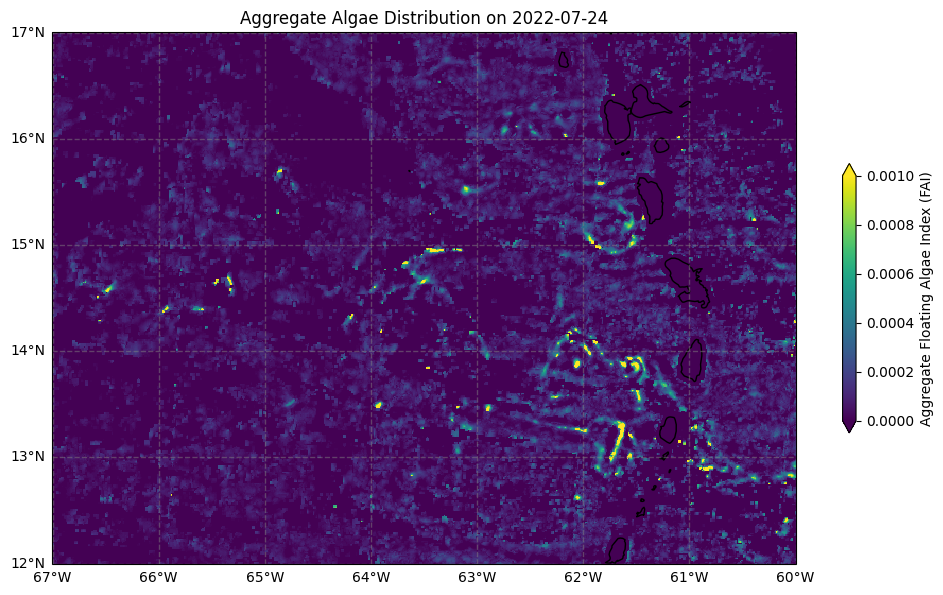

In [14]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 13, 00), interval=10)
    
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result
    visualize_aggregate(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

In the span of an hour, the clouds have not moved enough for us to get a clear image, so on its own and with the functions we have so far, an hour doesn't provide enough data to be able to detect the algae. 

# Search for a good temporal resolution
A day of averaging is too much and would defeat the purpose of our work. An hour is too little and the result has too much clouds. That's why we should try and find a compromise between temporal resolution and clarity.

But how could we quantify whether the solution we settle on is good enough or not? Maybe we could compare the Algae Ratio **$Ar= \frac{\text{number of pixels with algae}}{\text{number of pixels with algae in mean image}} $** to an Aglae Ratio Threshold **Art** where we'd consider an image to be satisfactory if **$Ar > Art$**.

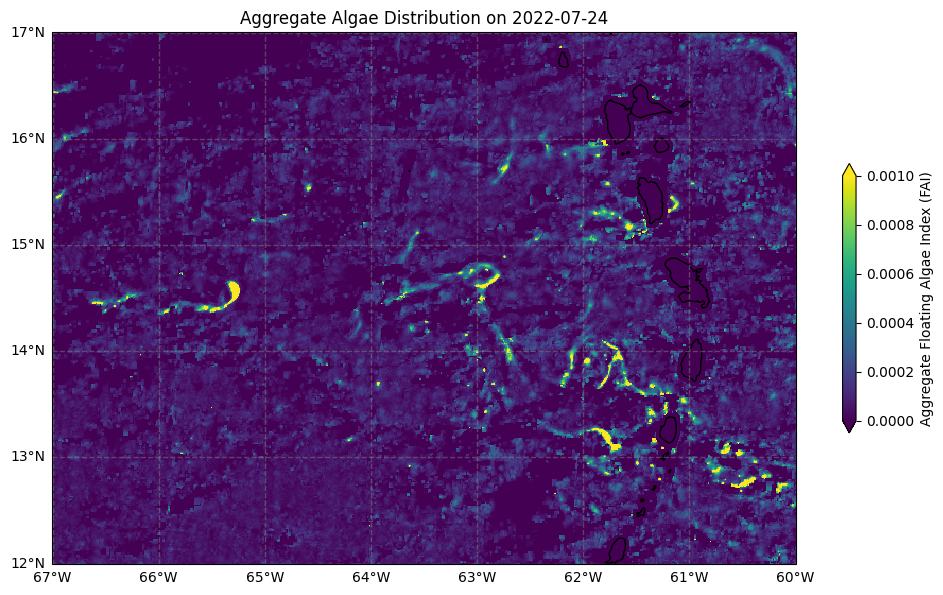

In [19]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 23, 12, 0), end_time=datetime(2022, 7, 23, 14, 00), interval=10)
    times2 = time_list(start_time=datetime(2022, 7, 23, 14, 0), end_time=datetime(2022, 7, 23, 16, 00), interval=10)
    
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range=(-67, -60))
    median_algae_distribution_2 = calculate_median(times2,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result
    visualize_aggregate(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(median_algae_distribution_2, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

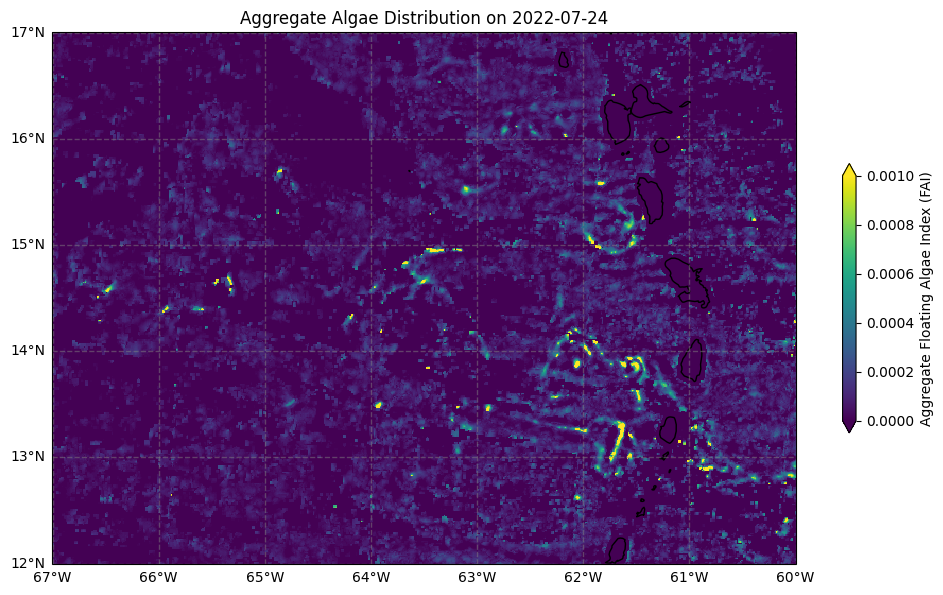

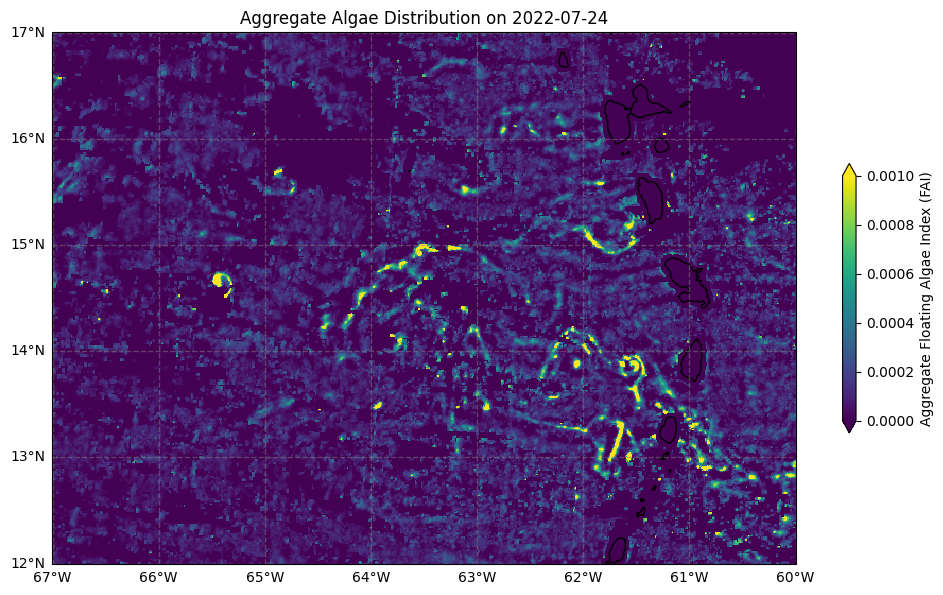

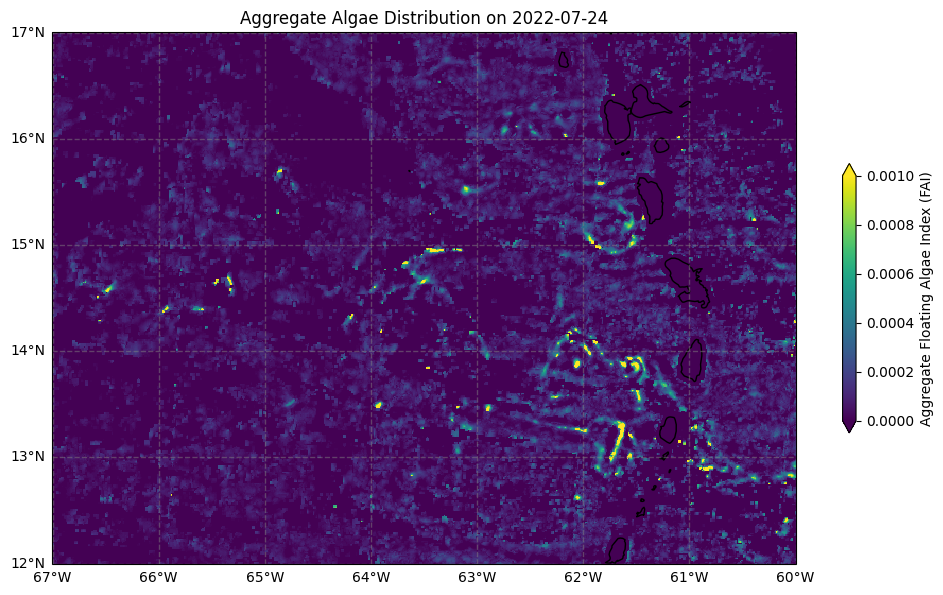

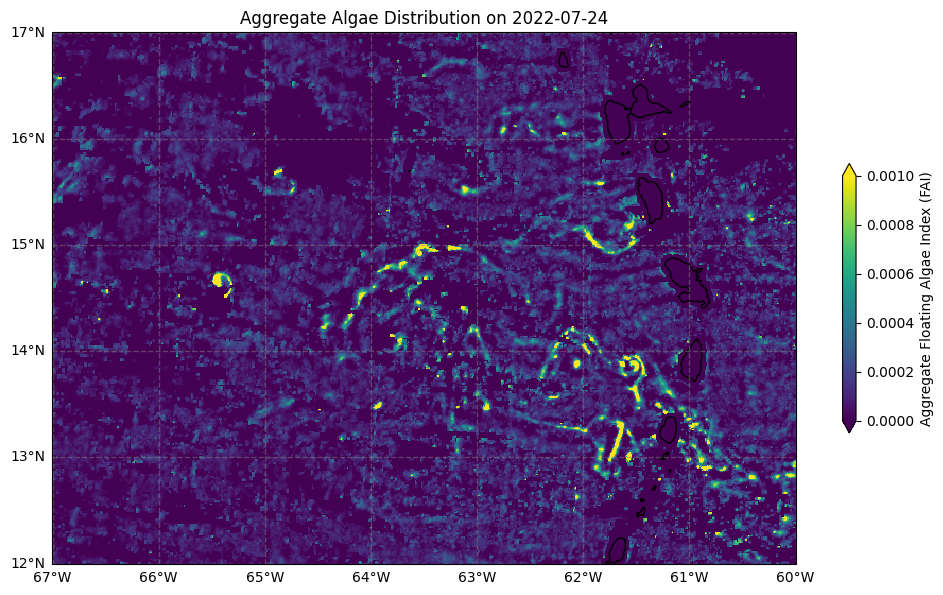

In [17]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 13, 00), interval=10)
    times2 = time_list(start_time=datetime(2022, 7, 24, 13, 0), end_time=datetime(2022, 7, 24, 14, 00), interval=10)
    times3 = time_list(start_time=datetime(2022, 7, 24, 14, 0), end_time=datetime(2022, 7, 24, 15, 00), interval=10)
    times4 = time_list(start_time=datetime(2022, 7, 24, 15, 0), end_time=datetime(2022, 7, 24, 16, 00), interval=10)
    
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range=(-67, -60))
    median_algae_distribution_2 = calculate_median(times2,lat_range=(12, 17), lon_range=(-67, -60))
    median_algae_distribution_3 = calculate_median(times,lat_range=(12, 17), lon_range=(-67, -60))
    median_algae_distribution_4 = calculate_median(times2,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result
    visualize_aggregate(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(median_algae_distribution_2, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(median_algae_distribution_3, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)
    visualize_aggregate(median_algae_distribution_4, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

We should come back to this, but for now we're going to work on 1-day ABI-GOES averages.

In [ ]:
if __name__ == '__main__':
    # Generating the time list
    times = time_list(start_time=datetime(2022, 9, 28, 10, 0), end_time=datetime(2022, 9, 28, 18, 50), interval=10)
    
    # Calculating the median data for this time period
    median_algae_distribution = calculate_median(times,lat_range=(12, 17), lon_range=(-67, -60))
    
    #Visualizing the result
    visualize_aggregate(median_algae_distribution, (12, 17), (-67, -60), color="viridis", vmax=0.001, threshold=0)

# Sub-Daily NetCDF

In [20]:
if __name__ == "__main__" :
    # Generating the time list
    times = time_list(start_time=datetime(2022, 7, 24, 12, 0), end_time=datetime(2022, 7, 24, 14, 00), interval=10)
    times_2 = time_list(start_time=datetime(2022, 7, 24, 14, 0), end_time=datetime(2022, 7, 24, 16, 00), interval=10)
    
    # Calculate median
    median_dataset = calculate_median(times, threshold=0)
    median_dataset_2 = calculate_median(times, threshold=0)
    
    # Save to NetCDF
    output_filepath = '/home/yahia/Documents/Jupyter/Sargassum/Images/Sub-Daily/median_20220724_12-14.nc'
    save_as_netcdf(median_dataset, output_filepath)
    output_filepath = '/home/yahia/Documents/Jupyter/Sargassum/Images/Sub-Daily/median_20220724_14-16.nc'
    save_as_netcdf(median_dataset, output_filepath)